In [66]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/mental-health-dataset/KB.json


In [67]:
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.model_selection import GridSearchCV, cross_val_score
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from wordcloud import WordCloud
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, SpatialDropout1D
from tensorflow.keras.utils import to_categorical


In [68]:
df = pd.read_json(path_or_buf='/kaggle/input/mental-health-dataset/KB.json')

In [69]:
df.head()

,intents
0,"{'tag': 'greeting', 'patterns': ['Hi', 'Hey', ..."
1,"{'tag': 'morning', 'patterns': ['Good morning'..."
2,"{'tag': 'afternoon', 'patterns': ['Good aftern..."
3,"{'tag': 'evening', 'patterns': ['Good evening'..."
4,"{'tag': 'night', 'patterns': ['Good night', 'N..."


In [70]:
df.tail()

,intents
75,"{'tag': 'fact-28', 'patterns': ['What do I do ..."
76,"{'tag': 'fact-29', 'patterns': ['How do I know..."
77,"{'tag': 'fact-30', 'patterns': ['How can I mai..."
78,"{'tag': 'fact-31', 'patterns': ['What's the di..."
79,"{'tag': 'fact-32', 'patterns': ['What's the di..."


In [71]:
tags = []
patterns = []
responses = []

for intent in df['intents']:
    for pattern in intent['patterns']:
        tags.append(intent['tag'])
        patterns.append(pattern)
        if 'responses' in intent:
            responses.append(intent['responses'][0])
        else:
            responses.append(None)

df = pd.DataFrame({'tag': tags, 'pattern': patterns, 'response': responses})
df.head()

,tag,pattern,response
0,greeting,Hi,Hello there. Tell me how are you feeling today?
1,greeting,Hey,Hello there. Tell me how are you feeling today?
2,greeting,Is anyone there?,Hello there. Tell me how are you feeling today?
3,greeting,Hi there,Hello there. Tell me how are you feeling today?
4,greeting,Hello,Hello there. Tell me how are you feeling today?


In [72]:
df.tail()

,tag,pattern,response
6250,fact-29,How do I know if I'm unwell?,"If your beliefs , thoughts , feelings or behav..."
6251,fact-30,How can I maintain social connections? What if...,"A lot of people are alone right now, but we do..."
6252,fact-31,What's the difference between anxiety and stress?,Stress and anxiety are often used interchangea...
6253,fact-32,What's the difference between sadness and depr...,"Sadness is a normal reaction to a loss, disapp..."
6254,fact-32,difference between sadness and depression,"Sadness is a normal reaction to a loss, disapp..."


In [73]:
df.columns

Index(['tag', 'pattern', 'response'], dtype='object')

In [74]:
df.shape

(6255, 3)

In [75]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6255 entries, 0 to 6254
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   tag       6255 non-null   object
 1   pattern   6255 non-null   object
 2   response  5609 non-null   object
dtypes: object(3)
memory usage: 146.7+ KB


In [76]:
df.isnull().sum()

tag           0
pattern       0
response    646
dtype: int64

In [77]:
df.describe()

,tag,pattern,response
count,6255,6255,5609
unique,80,3163,79
top,worthless,I'm not good enough for anyone to care about me.,I hear you. It's tough feeling this way.
freq,1107,69,1107


In [78]:
df['tag'].value_counts()

tag
worthless         1107
hate-you           694
scared             646
something-else     360
happy              348
                  ... 
fact-11              1
fact-10              1
fact-9               1
fact-8               1
fact-12              1
Name: count, Length: 80, dtype: int64

In [79]:
min_count = 10 
tag_counts = df['tag'].value_counts()
filtered_tags = tag_counts[tag_counts >= min_count].index

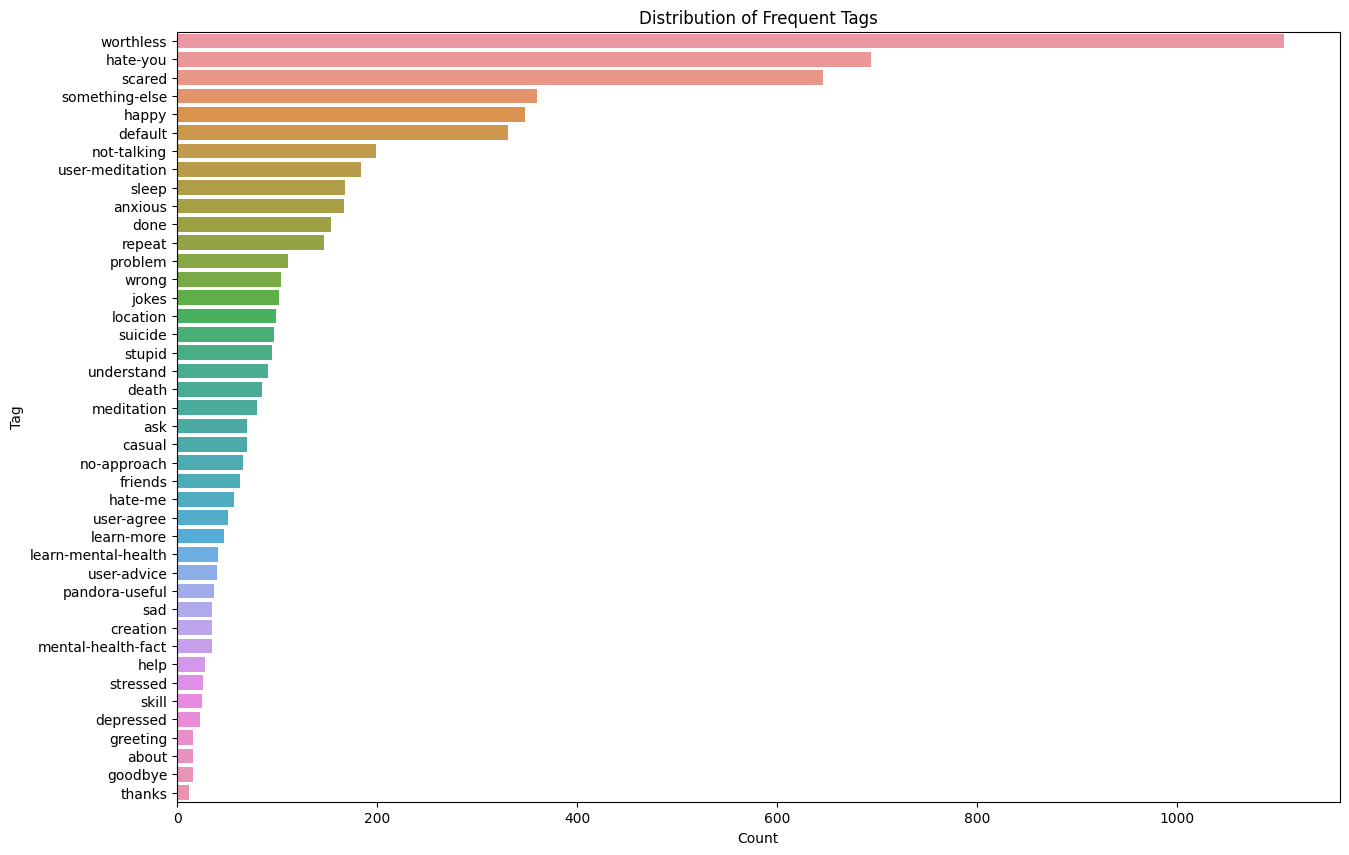

In [80]:
plt.figure(figsize=(15, 10))
sns.countplot(y=df[df['tag'].isin(filtered_tags)]['tag'], order=tag_counts[filtered_tags].index)
plt.title('Distribution of Frequent Tags')
plt.xlabel('Count')
plt.ylabel('Tag')
plt.show()

In [84]:
nltk.download('stopwords')
nltk.download('wordnet')

!unzip /usr/share/nltk_data/corpora/wordnet.zip -d /usr/share/nltk_data/corpora/

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
Archive:  /usr/share/nltk_data/corpora/wordnet.zip
   creating: /usr/share/nltk_data/corpora/wordnet/
  inflating: /usr/share/nltk_data/corpora/wordnet/lexnames  
  inflating: /usr/share/nltk_data/corpora/wordnet/data.verb  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.adv  
  inflating: /usr/share/nltk_data/corpora/wordnet/adv.exc  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.verb  
  inflating: /usr/share/nltk_data/corpora/wordnet/cntlist.rev  
  inflating: /usr/share/nltk_data/corpora/wordnet/data.adj  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.adj  
  inflating: /usr/share/nltk_data/corpora/wordnet/LICENSE  
  inflating: /usr/share/nltk_data/corpora/wordnet/citation.bib  
  inflating: /usr/share/nltk_data/

In [85]:
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

def preprocess_text(text):
    text = text.lower()
    text = ''.join([char for char in text if char.isalpha() or char == ' '])
    text = ' '.join([lemmatizer.lemmatize(word) for word in text.split() if word not in stop_words])
    return text

df['pattern_cleaned'] = df['pattern'].apply(preprocess_text)
df['response_cleaned'] = df['response'].apply(lambda x: preprocess_text(x) if x else "")

df.head()

,tag,pattern,response,pattern_cleaned,response_cleaned
0,greeting,Hi,Hello there. Tell me how are you feeling today?,hi,hello tell feeling today
1,greeting,Hey,Hello there. Tell me how are you feeling today?,hey,hello tell feeling today
2,greeting,Is anyone there?,Hello there. Tell me how are you feeling today?,anyone,hello tell feeling today
3,greeting,Hi there,Hello there. Tell me how are you feeling today?,hi,hello tell feeling today
4,greeting,Hello,Hello there. Tell me how are you feeling today?,hello,hello tell feeling today


In [86]:
vectorizer = TfidfVectorizer(max_features=5000)
X = vectorizer.fit_transform(df['pattern_cleaned']).toarray()
y = df['tag']

from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(X_train.shape, X_test.shape)
print(y_train.shape, y_test.shape)

(5004, 1750) (1251, 1750)
(5004,) (1251,)


In [87]:
nb_model = MultinomialNB()
nb_model.fit(X_train, y_train)
nb_pred = nb_model.predict(X_test)

In [88]:
svm_model = SVC(kernel='linear')
svm_model.fit(X_train, y_train)
svm_pred = svm_model.predict(X_test)

In [89]:
rf_model = RandomForestClassifier()
rf_model.fit(X_train, y_train)
rf_pred = rf_model.predict(X_test)

In [90]:
param_grid = {'C': [0.1, 1, 10], 'kernel': ['linear', 'rbf']}
grid_search = GridSearchCV(SVC(), param_grid, refit=True, verbose=2)
grid_search.fit(X_train, y_train)
svm_best = grid_search.best_estimator_

Fitting 5 folds for each of 6 candidates, totalling 30 fits


/opt/conda/lib/python3.10/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


[CV] END ...............................C=0.1, kernel=linear; total time=  18.4s
[CV] END ...............................C=0.1, kernel=linear; total time=  17.7s
[CV] END ...............................C=0.1, kernel=linear; total time=  18.0s
[CV] END ...............................C=0.1, kernel=linear; total time=  17.4s
[CV] END ...............................C=0.1, kernel=linear; total time=  17.8s
[CV] END ..................................C=0.1, kernel=rbf; total time=  24.2s
[CV] END ..................................C=0.1, kernel=rbf; total time=  23.9s
[CV] END ..................................C=0.1, kernel=rbf; total time=  23.4s
[CV] END ..................................C=0.1, kernel=rbf; total time=  23.5s
[CV] END ..................................C=0.1, kernel=rbf; total time=  23.7s
[CV] END .................................C=1, kernel=linear; total time=  14.6s
[CV] END .................................C=1, kernel=linear; total time=  14.6s
[CV] END ...................

In [91]:
nb_cv_scores = cross_val_score(nb_model, X, y, cv=5)
svm_cv_scores = cross_val_score(svm_best, X, y, cv=5)
rf_cv_scores = cross_val_score(rf_model, X, y, cv=5)

/opt/conda/lib/python3.10/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


In [92]:
def evaluate_model(model, X_test, y_test, y_pred):
    unique_labels = np.unique(np.concatenate((y_test, y_pred)))
    target_names = label_encoder.inverse_transform(unique_labels)
    print("Accuracy:", accuracy_score(y_test, y_pred))
    print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
    print("Classification Report:\n", classification_report(y_test, y_pred, target_names=target_names, zero_division=0))

In [93]:
print("Naive Bayes Model")
evaluate_model(nb_model, X_test, y_test, nb_pred)

Naive Bayes Model
Accuracy: 0.7426059152677857
Confusion Matrix:
 [[  0   0   0 ...   0   2   0]
 [  0   0   0 ...   0   1   0]
 [  0   0  17 ...   0   1   0]
 ...
 [  0   0   0 ...  34   0   0]
 [  0   0   0 ...   0 230   0]
 [  0   0   0 ...   0   2  15]]
Classification Report:
                      precision    recall  f1-score   support

              about       0.00      0.00      0.00         4
          afternoon       0.00      0.00      0.00         1
            anxious       1.00      0.53      0.69        32
                ask       1.00      0.53      0.70        15
             casual       0.00      0.00      0.00        14
           creation       0.00      0.00      0.00         6
              death       1.00      0.87      0.93        15
            default       0.80      0.79      0.79        56
          depressed       0.00      0.00      0.00         7
               done       0.92      0.71      0.80        34
            evening       0.00      0.00      

In [94]:
print("Cross-validation scores:", nb_cv_scores)

Cross-validation scores: [0.61470823 0.7226219  0.78497202 0.80015987 0.80415667]


In [95]:
print("Mean CV score:", np.mean(nb_cv_scores))

Mean CV score: 0.7453237410071942


In [96]:
print("\nRandom Forest Model")
evaluate_model(rf_model, X_test, y_test, rf_pred)


Random Forest Model
Accuracy: 0.86810551558753
Confusion Matrix:
 [[  0   0   0 ...   0   0   0]
 [  0   0   0 ...   0   0   0]
 [  0   0  32 ...   0   0   0]
 ...
 [  0   0   0 ...  34   0   0]
 [  0   0   0 ...   0 226   0]
 [  0   0   0 ...   0   1  17]]
Classification Report:
                      precision    recall  f1-score   support

              about       0.00      0.00      0.00         4
          afternoon       0.00      0.00      0.00         1
            anxious       0.97      1.00      0.98        32
                ask       0.94      1.00      0.97        15
             casual       0.20      0.79      0.32        14
           creation       0.33      0.17      0.22         6
              death       1.00      1.00      1.00        15
            default       0.96      0.84      0.90        56
          depressed       1.00      0.14      0.25         7
               done       0.96      0.74      0.83        34
            evening       0.00      0.00     

In [97]:
print("Cross-validation scores:", rf_cv_scores)
print("Mean CV score:", np.mean(rf_cv_scores))

Cross-validation scores: [0.6922462  0.88489209 0.92645883 0.93445244 0.92885691]
Mean CV score: 0.8733812949640288


In [98]:
print("\nBest SVM Model (Grid Search)")
svm_best_pred = svm_best.predict(X_test)
evaluate_model(svm_best, X_test, y_test, svm_best_pred)


Best SVM Model (Grid Search)
Accuracy: 0.8689048760991207
Confusion Matrix:
 [[  0   0   0 ...   0   0   0]
 [  0   0   0 ...   0   0   0]
 [  0   0  31 ...   0   0   0]
 ...
 [  0   0   0 ...  34   0   0]
 [  0   0   0 ...   0 228   0]
 [  0   0   0 ...   0   0  15]]
Classification Report:
                      precision    recall  f1-score   support

              about       0.00      0.00      0.00         4
          afternoon       0.00      0.00      0.00         1
            anxious       0.97      0.97      0.97        32
                ask       0.93      0.93      0.93        15
             casual       0.38      0.36      0.37        14
           creation       0.20      0.17      0.18         6
              death       0.94      1.00      0.97        15
            default       0.49      0.96      0.65        56
          depressed       0.00      0.00      0.00         7
               done       0.93      0.76      0.84        34
            evening       0.00    

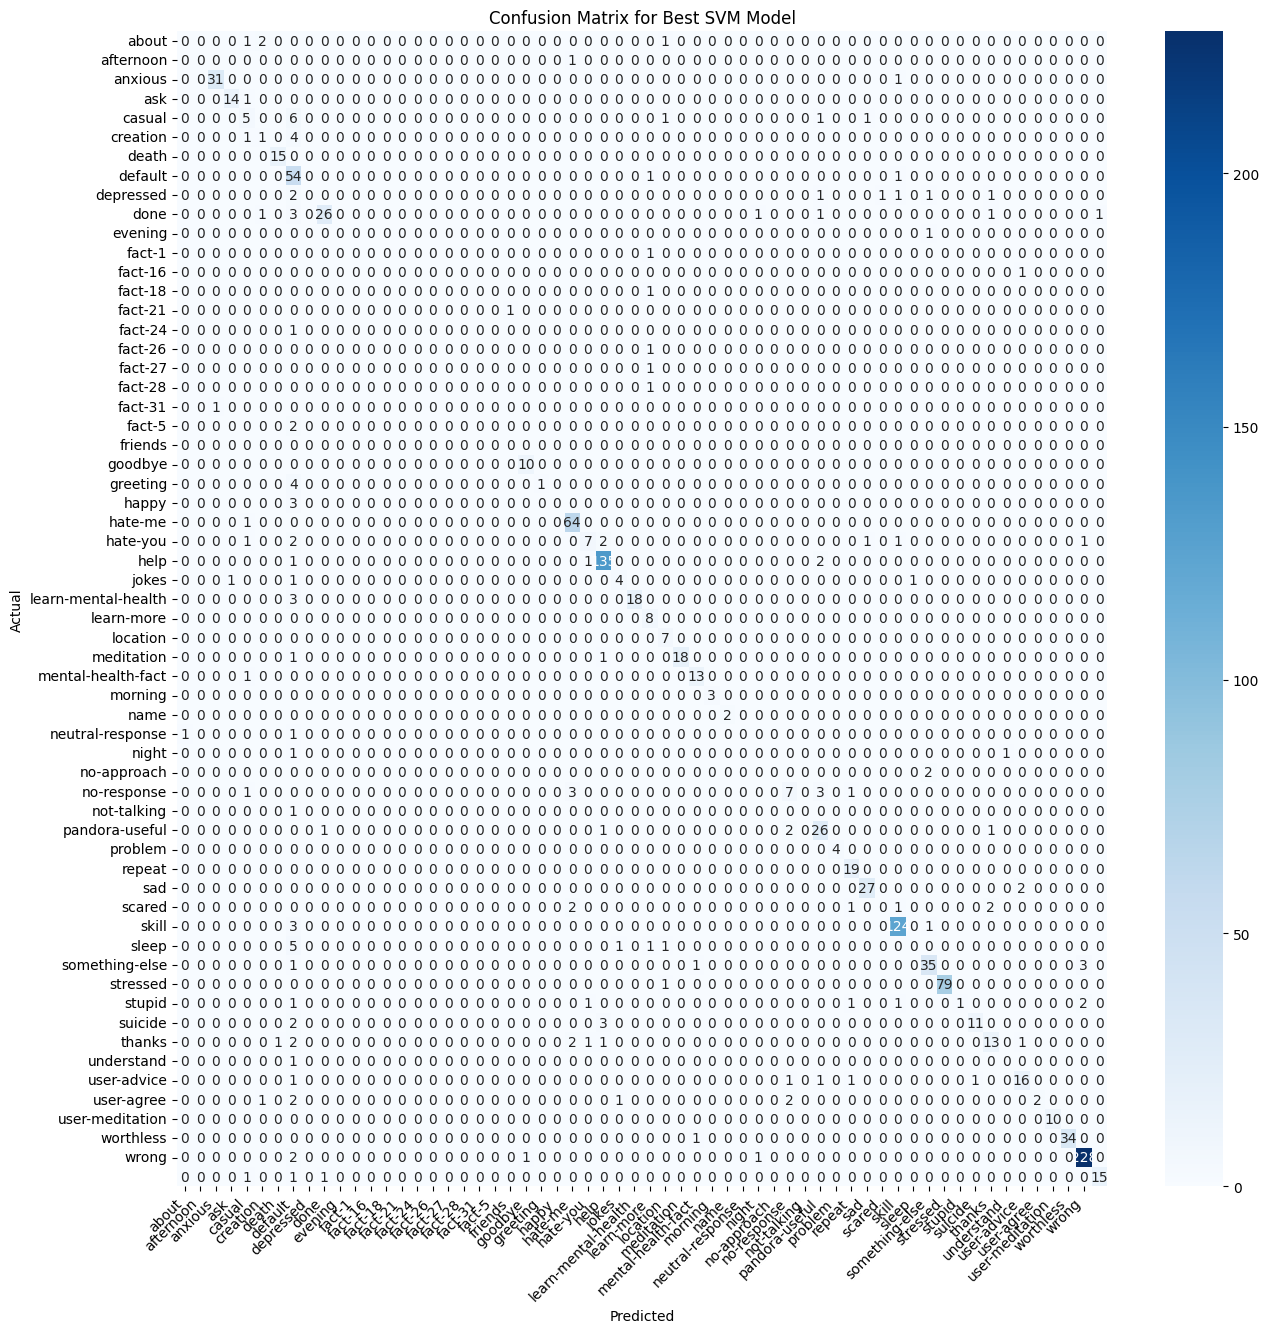

In [101]:
conf_matrix = confusion_matrix(y_test, svm_best_pred)
plt.figure(figsize=(15, 15))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.inverse_transform(np.unique(y_test)), yticklabels=label_encoder.inverse_transform(np.unique(y_test)))
plt.title('Confusion Matrix for Best SVM Model')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.show()

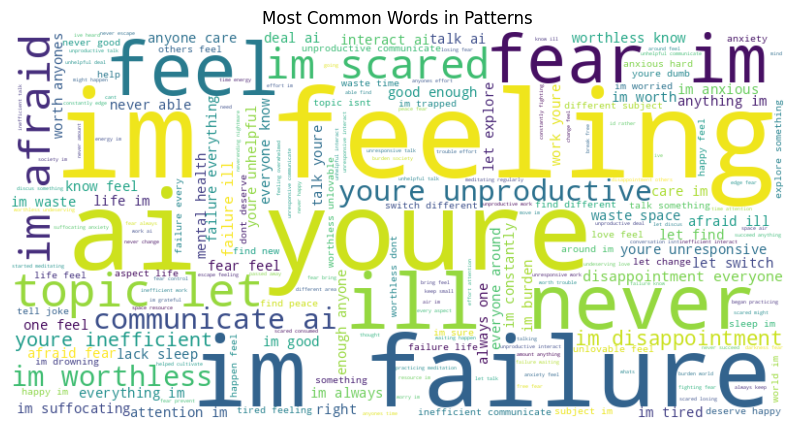

In [102]:
all_patterns = ' '.join(df['pattern_cleaned'])
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_patterns)

plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Most Common Words in Patterns')
plt.show()

In [103]:
MAX_NB_WORDS = 5000
MAX_SEQUENCE_LENGTH = 250
EMBEDDING_DIM = 100

tokenizer = Tokenizer(num_words=MAX_NB_WORDS)
tokenizer.fit_on_texts(df['pattern_cleaned'].values)
word_index = tokenizer.word_index
X_lstm = tokenizer.texts_to_sequences(df['pattern_cleaned'].values)
X_lstm = pad_sequences(X_lstm, maxlen=MAX_SEQUENCE_LENGTH)
y_lstm = pd.get_dummies(df['tag']).values

X_train_lstm, X_test_lstm, y_train_lstm, y_test_lstm = train_test_split(X_lstm, y_lstm, test_size=0.2, random_state=42)

In [104]:
model_lstm = Sequential()
model_lstm.add(Embedding(MAX_NB_WORDS, EMBEDDING_DIM, input_length=MAX_SEQUENCE_LENGTH))
model_lstm.add(SpatialDropout1D(0.2))
model_lstm.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model_lstm.add(Dense(len(y_lstm[0]), activation='softmax'))
model_lstm.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

history = model_lstm.fit(X_train_lstm, y_train_lstm, epochs=5, batch_size=64, validation_data=(X_test_lstm, y_test_lstm), verbose=2)

Epoch 1/5


/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


79/79 - 26s - 327ms/step - accuracy: 0.2374 - loss: 3.2060 - val_accuracy: 0.3941 - val_loss: 2.4749
Epoch 2/5
79/79 - 22s - 280ms/step - accuracy: 0.5378 - loss: 1.9902 - val_accuracy: 0.6043 - val_loss: 1.6025
Epoch 3/5
79/79 - 23s - 287ms/step - accuracy: 0.6515 - loss: 1.3937 - val_accuracy: 0.7034 - val_loss: 1.2640
Epoch 4/5
79/79 - 40s - 510ms/step - accuracy: 0.7516 - loss: 1.0688 - val_accuracy: 0.8002 - val_loss: 1.0394
Epoch 5/5
79/79 - 22s - 280ms/step - accuracy: 0.8279 - loss: 0.8415 - val_accuracy: 0.8098 - val_loss: 0.8879


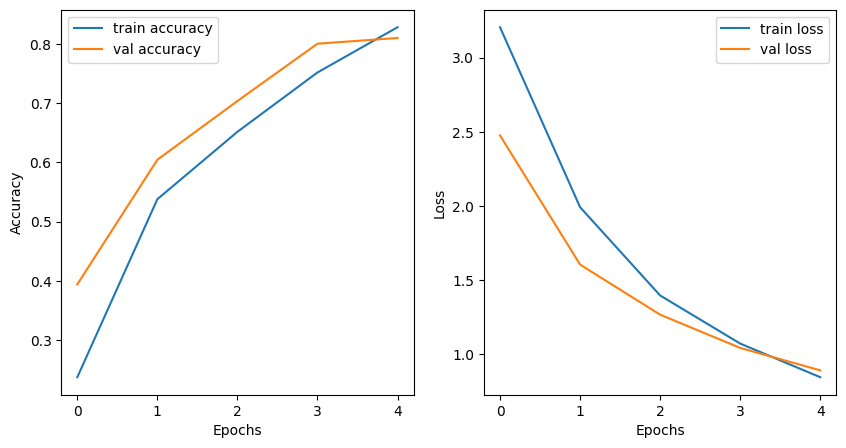

In [105]:
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='train accuracy')
plt.plot(history.history['val_accuracy'], label='val accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [106]:
y_test_lstm_pred = model_lstm.predict(X_test_lstm)
y_test_lstm_pred_class = np.argmax(y_test_lstm_pred, axis=1)
y_test_lstm_class = np.argmax(y_test_lstm, axis=1)

print("LSTM Model")
evaluate_model(model_lstm, X_test_lstm, y_test_lstm_class, y_test_lstm_pred_class)

40/40 ━━━━━━━━━━━━━━━━━━━━ 3s 63ms/step
LSTM Model
Accuracy: 0.8097521982414069
Confusion Matrix:
 [[  0   0   0 ...   0   0   0]
 [  0   0   0 ...   0   0   0]
 [  0   0  31 ...   0   0   0]
 ...
 [  0   0   0 ...  34   0   0]
 [  0   0   0 ...   0 228   0]
 [  0   0   0 ...   0   1  12]]
Classification Report:
                      precision    recall  f1-score   support

              about       0.00      0.00      0.00         4
          afternoon       0.00      0.00      0.00         1
            anxious       0.94      0.97      0.95        32
                ask       0.64      0.93      0.76        15
             casual       0.00      0.00      0.00        14
           creation       0.00      0.00      0.00         6
              death       1.00      0.93      0.97        15
            default       0.47      0.95      0.63        56
          depressed       0.00      0.00      0.00         7
               done       0.52      0.79      0.63        34
            e